# Target Pursuit: Machine Learning Model - Abhaysai Vemula & Shiril Reddy
## Set Up Code

In [16]:
import random

#Initializing the Ship as Per The Instructions Laid out
def get_cells_with_1_open_neighbor(status, ship):
    res = []
    for i in range(1,len(ship)-1):
        for j in range(1,len(ship[i])-1):
            if ship[i][j] != status:
                continue
            count_open_neighbors = 0

            if i-1>=0:
                if ship[i-1][j] == "open":
                    count_open_neighbors+=1
            if i+1<len(ship):
                if ship[i+1][j] == "open":
                    count_open_neighbors+=1
            if j-1>=0:
                if ship[i][j-1] == "open":
                    count_open_neighbors+=1
            if j+1<len(ship[i]):
                if ship[i][j+1] == "open":
                    count_open_neighbors+=1

            if count_open_neighbors == 1:
                res.append((i,j))
    return res

#Create Ship
def create_ship():
    r_x, r_y = 30, 30
    ship = [["blocked" for n in range(r_x)] for m in range(r_y)]

    row = random.randint(1, r_x-2)
    col = random.randint(1, r_y-2)
    ship[row][col] = "open"

    while True:
        cells_to_open = get_cells_with_1_open_neighbor("blocked", ship)
        if cells_to_open:
            i,j = cells_to_open[random.randint(0, len(cells_to_open)-1)]
            ship[i][j] = "open"
        else:
            break   

    deadends = get_cells_with_1_open_neighbor("open", ship)
    chosen_deadends = random.sample(deadends, len(deadends)//2)
    for i, j in chosen_deadends:
        neighbors = []
        if i-1>=0:
            if ship[i-1][j] == "blocked":
                neighbors.append((i-1,j))
        if j-1>=0:
            if ship[i][j-1] == "blocked":
                neighbors.append((i,j-1))  
        if i+1<len(ship):
            if ship[i+1][j] == "blocked":
                neighbors.append((i+1,j))
        if j+1<len(ship[i]):
            if ship[i][j+1] == "blocked":
                neighbors.append((i,j+1))
        if not neighbors:
            continue
        index = random.randint(0, len(neighbors)-1)
        row, col = neighbors[index]
        ship[row][col] = "open"

    for i in range(r_x):
        ship[i][0] = "blocked"
        ship[i][r_x-1] = "blocked"
        ship[0][i] = "blocked"
        ship[r_x-1][i] = "blocked"
    
    return ship

In [17]:
from collections import deque

#Initializes the creation of the ship, bot position, rat position and neccessary knowledge bases
def start_settings():
    ship = create_ship()
    row = random.randint(1, 28)
    col = random.randint(1, 28)

    while ship[row][col] == "blocked":
        row = random.randint(1, 28)
        col = random.randint(1, 28)

    bot_pos = (row, col)
    possible_bot_pos = {(x, y) for x in range(1, 29) for y in range(1, 29) if ship[x][y] == "open"}

    row = random.randint(1, 28)
    col = random.randint(1, 28)
    while ship[row][col] == "blocked":
        row = random.randint(1, 28)
        col = random.randint(1, 28)

    rat_pos = (row, col)
    possible_rat_pos = {}
    count = 0
    for i in range(30):
        for j in range(30):
            if ship[i][j] == "open":
                possible_rat_pos[(i,j)] = 1
                count+=1

    possible_rat_pos = {key: value / count for key, value in possible_rat_pos.items()}

    return[ship, bot_pos, possible_bot_pos, rat_pos, possible_rat_pos]

In [18]:
import math
from collections import deque
import copy
import matplotlib.pyplot as plt

#This function utilizes BFS to return an array of directions which is the shortest path between two cells
def shortest_path_to_possible_rat_pos(ship, bx, by, prx, pry):
    q = deque()
    q.append((bx,by))

    #keep track of the preceding cell to the current cell
    precede = {(bx,by) : None}
    visit = set()
    visit.add((bx,by))

    while q:
        i, j = q.popleft()
        index = (i, j)

        #if the current cell is the possible rat cell create a list of directions from the start
        if i == prx and j == pry:
            directions = []

            #utilize the precede dictionary to reverse the list of directions
            while index is not None:
                directions.append(index)
                index = precede[index]

            #return a reversed list of directions by utilizing precede I calculate the path from the bot to the possible rat cell
            directions = directions[::-1]
            return directions[1:]

        #next 4 if statements check the neighbors and if they are valid are added to the queue
        if i-1>=0 and (i-1, j) not in visit:
            if ship[i-1][j] != "blocked":
                q.append((i-1,j))
                visit.add((i-1,j))
                precede[(i-1,j)] = index

        if j-1>=0 and (i, j-1) not in visit:
            if ship[i][j-1] != "blocked":
                q.append((i,j-1))
                visit.add((i,j-1))
                precede[(i,j-1)] = index

        if i+1<len(ship) and (i+1, j) not in visit:
            if ship[i+1][j] != "blocked":
                q.append((i+1,j))
                visit.add((i+1,j))
                precede[(i+1,j)] = index

        if j+1<len(ship[i]) and (i, j+1) not in visit:
            if ship[i][j+1] != "blocked":
                q.append((i,j+1))
                visit.add((i,j+1))
                precede[(i,j+1)] = index

    #if there is no path return an empty list
    return []

#This function returns the probability of getting a ping depending on the distance between the bot and the rat utilizing the formula given
def get_ping(bx, by, rx, ry, a):
    d = abs(bx-rx) + abs(by-ry)
    prob_ping = math.exp(-1*a*(d-1))
    return prob_ping

#This function updates our knowledge base based on if we here a ping or we dont here a ping
def update_possible_rat_pos(bx, by, ping, a, possible_rat_pos):
    #Formula: p(rat at i,j | ping) = p(ping | rat at i,j) * p(rat at ij ) / p(ping)
    #Formula: p(rat at i,j | not_ping) = p(not_ping | rat at i,j) * p(rat at ij ) / p(not_ping overall)

    #New knowledge base that we return
    new_possible_rat_pos = new_possible_rat_pos = copy.deepcopy(possible_rat_pos)

    #Use the law of total probability to calculate the overall probability of hearing a ping
    prob_ping = 0
    for index, prob_rat_at_xy in possible_rat_pos.items():
        x,y = index
        prob_ping += get_ping(bx, by, x, y, a)*prob_rat_at_xy
    
    #Use the law of total probability to calculate the overall probability of not hearing a ping
    prob_not_ping = 0
    for index, prob_rat_at_xy in possible_rat_pos.items():
        x,y = index
        prob_not_ping_given_rat_xy = 1 - get_ping(bx, by, x, y, a)
        prob_not_ping += prob_not_ping_given_rat_xy*prob_rat_at_xy
    
    #The following code adjusts the probabilites in the knowledge base utilizing the formula we have depending on ping or not ping
    if ping:
        for index, prob_rat_at_xy in possible_rat_pos.items():
            x,y = index

            if x==bx and y==by:
                new_possible_rat_pos[index] = 0
                continue

            #calculate p(ping | rat at i,j)
            prob_ping_given_rat_at_xy = get_ping(bx, by, x, y, a)

            #calculate overall prob of getting a ping
            #p(rat in each open cell) * p(ping of the bot to that cell)
            new_possible_rat_pos[index] = (prob_ping_given_rat_at_xy * prob_rat_at_xy) / prob_ping
    else:
        for index, prob_rat_at_xy in possible_rat_pos.items():
            x,y = index
            
            if x==bx and y==by:
                new_possible_rat_pos[index] = 0
                continue
            #calculate p(ping | rat at i,j)
            prob_not_ping_given_rat_at_xy = 1 - get_ping(bx, by, x, y, a)
            new_possible_rat_pos[index] = (prob_not_ping_given_rat_at_xy * prob_rat_at_xy) / prob_not_ping
    
    #Normalize the probabilites
    total_prob = sum(new_possible_rat_pos.values())
    return {key: value / total_prob for key, value in new_possible_rat_pos.items()}


In [19]:
from collections import defaultdict

#This function returns the number of blocked cells
def get_num_blocked_neighbors(ship,x,y):
    count = 0

    #Checks all 8 directions and if it is blocked increases the count
    if ship[x - 1][y] == "blocked": 
        count += 1
    if ship[x + 1][y] == "blocked": 
        count += 1
    if ship[x][y - 1] == "blocked": 
        count += 1
    if ship[x][y + 1] == "blocked": 
        count += 1
    if ship[x - 1][y - 1] == "blocked": 
        count += 1
    if ship[x - 1][y + 1] == "blocked": 
        count += 1
    if ship[x + 1][y - 1] == "blocked": 
        count += 1
    if ship[x + 1][y + 1] == "blocked": 
        count += 1

    return count

#Function to update the possible positions of the bot depending on how many blocked neighbors it has
def update_possible_bot_pos_by_neighbors(ship, num_blocked_neighbors, possible_bot_pos):

    #Create a new set to return once the calculations are finished
    new_possible_bot_pos = set()

    #Loop through all of the possible positions the bot could be in
    for (x,y) in possible_bot_pos:
        #Check how many blocked neighbors this cell has
        curr_pos_blocked_neighbors = get_num_blocked_neighbors(ship, x,y)

        #If it has the same number of blocked cells as desired we add it to our new set
        if curr_pos_blocked_neighbors == num_blocked_neighbors:
            new_possible_bot_pos.add((x,y))
        
    return new_possible_bot_pos

#Function to update the possible positions of the bot depending on the direction we move in
def update_possible_bot_pos_by_move(ship, direction, move_success, possible_bot_pos):
    
    #Create a new set to return once the calculations are finished
    new_possible_bot_pos = set()

    #Loop through all of the possible positions the bot could be in and if it is possible to move in the desired direction from that cell we add it to the set otherwise we do not
    for (x, y) in possible_bot_pos:

        #The following if statements go through what the desired direction is and check if it is possible to move in that direction from each possible location of the bot
        if direction == "up":
            if move_success and ship[x - 1][y] == "open":
                new_possible_bot_pos.add((x - 1, y))
            elif not move_success and ship[x - 1][y] == "blocked":
                new_possible_bot_pos.add((x, y))
        elif direction == "down":
            if move_success and ship[x + 1][y] == "open":
                new_possible_bot_pos.add((x + 1, y))
            elif not move_success and ship[x + 1][y] == "blocked":
                new_possible_bot_pos.add((x, y))
        elif direction == "left":
            if move_success and ship[x][y - 1] == "open":
                new_possible_bot_pos.add((x, y - 1))
            elif not move_success and ship[x][y - 1] == "blocked":
                new_possible_bot_pos.add((x, y))
        elif direction == "right":
            if move_success and ship[x][y + 1] == "open":
                new_possible_bot_pos.add((x, y + 1))
            elif not move_success and ship[x][y + 1] == "blocked":
                new_possible_bot_pos.add((x, y))

    return new_possible_bot_pos

#Function to calculate the utility of sensing blocked neighbors based on possible bot positions
def get_utility_sense_neighbors(ship, possible_bot_pos):
    
    # Helper function to count the number of blocked neighbors for each possible bot position
    def get_blocked_cells():
        blocked_cells = defaultdict(int)
        for (x, y) in possible_bot_pos:
            count = get_num_blocked_neighbors(ship, x, y) 
            blocked_cells[count] += 1 
        return blocked_cells

    total_cells = len(possible_bot_pos) 
    blocked_cells = get_blocked_cells() 

    expected_num_cells_reduced = 0

    #Calculate expected number of cells reduced by sensing for blocked neighbors
    for count, cell_count in blocked_cells.items():
        num_cells_reduced = total_cells - cell_count
        expected_num_cells_reduced += num_cells_reduced * (cell_count / total_cells)
    
    return expected_num_cells_reduced

# Function to calculate the utility of moving in each possible direction
def get_utility_move(ship, possible_bot_pos):
    
    #function to calculate the probability of moving in each direction
    def get_direction_probs():
        direction_probs = defaultdict(int)
        for (x, y) in possible_bot_pos:
            # Check each direction for every possible cell to see if it's open and increment respective direction count
            if ship[x-1][y] == "open":
                direction_probs["up"] += 1
            if ship[x+1][y] == "open":
                direction_probs["down"] += 1
            if ship[x][y-1] == "open":
                direction_probs["left"] += 1
            if ship[x][y+1] == "open":
                direction_probs["right"] += 1
        return direction_probs

    total_cells = len(possible_bot_pos)  
    direction_probs = get_direction_probs() 

    expected_num_cells_reduced = 0

    # Calculate expected number of cells reduced by moving in each direction
    for direction, cell_count in direction_probs.items():
        num_cells_reduced = total_cells - cell_count
        expected_num_cells_reduced += num_cells_reduced * (cell_count / total_cells)
    
    return expected_num_cells_reduced

# Phase 1 for my bot
def my_phase_1(ship, bot_pos, possible_bot_pos, possible_rat_pos):
    x, y = bot_pos  # Initial bot position
    wiggle = []  # List to track movement patterns
    last_move_sense_neighbors = False  # Flag to track last move type
    num_sense_blocked_neighbors = 0  # Count of sense operations
    num_attempted_moves = 0  # Count of attempted moves

    states = []
    time = 0

    # Loop until only one possible bot position is left
    while True:

        #Appends the current states of the ship to the states array in order to be used for training data
        states.append([ship, possible_rat_pos, possible_bot_pos, num_sense_blocked_neighbors + num_attempted_moves])

        if len(possible_bot_pos) == 1:
            return (possible_bot_pos.pop(), num_sense_blocked_neighbors + num_attempted_moves, states)
        
        # Calculate utilities for sensing neighbors and moving
        utility_sense_neighbors = get_utility_sense_neighbors(ship, possible_bot_pos)
        utility_move = get_utility_move(ship, possible_bot_pos)

        # Choose the action depending on which utility is higher - which action causes the greatest reduction in number of possible bot positions
        if utility_sense_neighbors >= utility_move and not last_move_sense_neighbors:
            #Sensing two times in a row from the same position does not provide much benefit

            #Code below senses for blocked neighbors then adjusts the possible bot positions
            num_sense_blocked_neighbors += 1  
            num_blocked_neighbors = get_num_blocked_neighbors(ship, x, y)  
            possible_bot_pos = update_possible_bot_pos_by_neighbors(ship, num_blocked_neighbors, possible_bot_pos)
            last_move_sense_neighbors = True
        else:

            last_move_sense_neighbors = False
            num_attempted_moves += 1

            # Check for a wiggle and if it exists randomly choose a direction
            if len(wiggle) > 3 and (wiggle[0] == wiggle[2] and wiggle[1] == wiggle[3]):
                directions = ["up", "down", "left", "right"]
                direction = random.choice(directions)
            else:
                # Calculate probabilities for each direction based on open paths
                direction_counts = {
                    "up": 0,
                    "down": 0,
                    "left": 0,
                    "right": 0
                }
                for (x, y) in possible_bot_pos:
                    if ship[x - 1][y] == "open":
                        direction_counts["up"] += 1
                    if ship[x + 1][y] == "open":
                        direction_counts["down"] += 1
                    if ship[x][y - 1] == "open":
                        direction_counts["left"] += 1
                    if ship[x][y + 1] == "open":
                        direction_counts["right"] += 1

                # Calculate direction probabilities based on counts
                direction_prob = {key: value / len(possible_bot_pos) for key, value in direction_counts.items()}
                directions = list(direction_prob.keys())
                probabilities = list(direction_prob.values())
                direction = random.choices(directions, probabilities, k=1)[0]

            # Attempt to move in the selected direction and update position
            move_success = False
            if direction == "up" and ship[x-1][y] == "open":
                x -= 1
                move_success = True
            if direction == "down" and ship[x+1][y] == "open":
                x += 1
                move_success = True
            if direction == "left" and ship[x][y-1] == "open":
                y -= 1
                move_success = True
            if direction == "right" and ship[x][y+1] == "open":
                y += 1
                move_success = True

            #Update the wiggle list to keep track of our movements
            if move_success:
                wiggle.append(direction)
                if len(wiggle) > 4:
                    wiggle = wiggle[1:]

            # Update possible bot positions based on the move and if it was successful
            possible_bot_pos = update_possible_bot_pos_by_move(ship, direction, move_success, possible_bot_pos)
            
        time+=1

In [20]:
# Function to select the position with the highest probability of having the rat and closest to the current bot position
def select_best_position(ship, bx, by, possible_rat_pos):
    max_prob = max(possible_rat_pos.values())
    max_prob_cells = [pos for pos, prob in possible_rat_pos.items() if prob == max_prob]

    prx, pry = min(max_prob_cells, key=lambda pos: len(shortest_path_to_possible_rat_pos(ship, bx, by, pos[0], pos[1])))

    return prx, pry

# My Bot's Phase 2
def my_bot_phase_2(ship, bot_pos, rat_pos, possible_rat_pos, a):

    #Initialze variables
    bx, by = bot_pos 
    rx, ry = rat_pos 
    time = 0
    num_ping = 0 
    num_moves = 0 
    mandatory_ping = False  # Check for mandatory pinging 
    visit = set()  # Set to track visited positions when moving without pinging
    visit.add((bx, by)) 
    commit = False  # Check to commit to a a high probability cell
    commit_next_move = False  # Check to commit on the next move

    states = []

    while True:

        #Appends the current states of the ship to the states array in order to be used for training data
        states.append([ship, possible_rat_pos, {(bx,by)}, num_ping + num_moves])
        
        if 0 < a <= 0.1:
            ping_factor = 0.6
        if 0.1 < a <= 0.2:
            ping_factor = 0.55   

        #Factor to see how concentrated the values of the rat probability distribution are
        concentration = (ping_factor - max(possible_rat_pos.values()))
  
        #If concentration is negative (very high probability value) commit to that cell
        if (concentration < 0 and not mandatory_ping) or commit:
            # Select the best position to move to
            prx, pry = select_best_position(ship, bx, by, possible_rat_pos)
            num_moves += len(shortest_path_to_possible_rat_pos(ship, bx, by, prx, pry))  
            bx, by = prx, pry

            #Set mandatory_ping to ensure the next action is a ping
            mandatory_ping = True
            visit.add((prx, pry))

            commit = False

        # If concentration is low ping or if mandatory ping is true
        elif random.random() < concentration or mandatory_ping:
            mandatory_ping = False  
            num_ping += 1 
            
            # Return if the rat is found
            if bx == rx and by == ry:
                # return [(bx, by), num_ping, num_moves, num_ping + num_moves]
                return [num_ping + num_moves, states]
            
            # If the rat is not at the current cell set the probability to 0 and normalize
            possible_rat_pos[(bx, by)] = 0
            possible_rat_pos = {key: value / sum(possible_rat_pos.values()) for key, value in possible_rat_pos.items()}

            # Calculate the probability of hearing a ping and if ping happens
            prob_ping = get_ping(bx, by, rx, ry, a)
            ping = random.random() < prob_ping

            #Clear the visited cells
            visit.clear()

            # Update knowledge base depending on the ping result
            possible_rat_pos = update_possible_rat_pos(bx, by, ping, a, possible_rat_pos)
            
            #Set commit to true if commit next move is true
            if commit_next_move:
                commit = True
                commit_next_move = False

        #Code to choose how to move
        else:
            num_moves += 1
            #Select the best position to move to
            prx, pry = select_best_position(ship, bx, by, possible_rat_pos)
            
            # Find the shortest path to the target position
            directions = shortest_path_to_possible_rat_pos(ship, bx, by, prx, pry) 

            if directions:
                
                #If the current cell is cell we need to move to ping and commit
                if directions[0] in visit:
                    mandatory_ping = True
                    commit_next_move = True
                else:
                    
                    #Move one position towards the best position
                    bx, by = directions[0]
                    visit.add((bx, by))
            else:
                #If the current cell is selected as the best position ping then commit to readjust the knowledge base
                mandatory_ping = True
                commit_next_move = True
      
        time += 1

# Project 3 Code

## Create Training Data

In [21]:
import numpy as np

#Create a class to capture the raw data and transform it into the neccessary states -> contains both input data and output data
class RawData:
    def __init__(self, ship_state, knowledge_base_state, bot_pos, moves_left):
        #Input Data
        self.ship_state = self.convert_ship_state(ship_state)
        self.knowledge_base_state = knowledge_base_state
        self.bot_pos = bot_pos

        #Output Data
        self.moves_left = moves_left

    #Convert the ship state into a numpy array
    def convert_ship_state(self, ship_state):
        return np.array([[1 if cell == "blocked" else 0 for cell in row] for row in ship_state])

    # Get methods in order to retrieve the data
    def get_ship_state(self):
        return self.ship_state

    def get_knowledge_base_state(self):
        return self.knowledge_base_state

    def get_bot_pos(self):
        return self.bot_pos

    def get_moves_left(self):
        return self.moves_left


In [22]:
import numpy as np
import torch
import pandas as pd

init_conditions = None

#Function to run my project 2 bot and create the testing data and training data
def get_raw_data():
    global init_conditions
    num_simulations = 1

    #Contains the raw training data
    training_raw_data = []

    #Contains the raw testing data
    testing_raw_data = []
    for i in range(num_simulations):
        states = []

        #Create the initial conditions to run the my project 2 bot code
        init_conditions = start_settings()
        init_ship, init_bot_pos, init_possible_bot_pos, init_rat_pos, init_possible_rat_pos = init_conditions

        #Run my phase 1 and phase 2 with the initialized settings
        for i in range(70):
            print(i)
            bot_pos, p1_moves_and_senses, p1_states = my_phase_1(init_ship, init_bot_pos, init_possible_bot_pos, init_possible_rat_pos)
            p2_moves_and_senses, p2_states = my_bot_phase_2(init_ship, bot_pos, init_rat_pos, init_possible_rat_pos, 0.2)

            #Calculate the total moves & senses from both phases
            total_moves = p1_moves_and_senses + p2_moves_and_senses

            #Transform the output data from time to number of moves left for phase 1
            for state in p1_states:
                state[3] = total_moves - state[3]
            
            #Transform the output data from time to number of moves left for phase 2
            for state in p2_states:
                state[3] = total_moves - p1_moves_and_senses - state[3]
            
            #Extend states to include phase 1 and phase 2 states in the appropriate order
            states.extend(p1_states)
            states.extend(p2_states)

            #Using the states create Raw Data objects for each state
            for state in states:
                raw_data = RawData(state[0], state[1], state[2], state[3])
                training_raw_data.append(raw_data)

        ## For Validation Data
        print("make testing data")
        test_states = []

        #The following code re runs the my phase 1 and phase 2 on with the same initial settings to capture the data for testing
        val_bot_pos, val_p1_moves_and_senses, val_p1_states = my_phase_1(init_ship, init_bot_pos, init_possible_bot_pos, init_possible_rat_pos)
        val_p2_moves_and_senses, val_p2_states = my_bot_phase_2(init_ship, val_bot_pos, init_rat_pos, init_possible_rat_pos, 0.2)


        #The following code is the same as for the training data but seperated for testing purposes (Note: testing and val are the same thing in this code)
        val_total_moves = val_p1_moves_and_senses + val_p2_moves_and_senses

        for state in val_p1_states:
            state[3] = val_total_moves - state[3]
        
        for state in val_p2_states:
            state[3] = val_total_moves - p1_moves_and_senses - state[3]
        
        test_states.extend(val_p1_states)
        test_states.extend(val_p2_states)

        for state in test_states:
            raw_data = RawData(state[0], state[1], state[2], state[3])
            testing_raw_data.append(raw_data)

        # Return raw training and testing data
        return [training_raw_data, testing_raw_data]

#Functinon to create the input tensor
def create_input_tensor(raw_data):
    grid_shape = (30, 30)

    #Get the ship state and reform it into a numpy array
    ship_state = raw_data.get_ship_state()
    ship_state_grid = np.array(ship_state)  

    #Get the possible rat position knowledge base transform it from a dictionary into a numpy array
    rat_kb_state = raw_data.get_knowledge_base_state()
    rat_kb_grid = np.array([[rat_kb_state.get((r, c), 0.0) for c in range(grid_shape[1])] for r in range(grid_shape[0])])


    #Get the possible bot position knowledge base transform it from a dictionary into a numpy array
    bot_kb_state = raw_data.get_bot_pos()
    bot_kb_grid = np.zeros(grid_shape)
    
    #normalize
    for (r, c) in bot_kb_state:
        bot_kb_grid[r, c] = 1 / len(bot_kb_state)  

    #normalize
    if np.sum(rat_kb_grid) > 0:
        rat_kb_grid = rat_kb_grid / np.sum(rat_kb_grid)  
    
    #normalize
    if np.sum(bot_kb_grid) > 0:
        bot_kb_grid = bot_kb_grid / np.sum(bot_kb_grid)


    #Create a 3 x 30 x 30 input tensor merging ship state, the bot position state, and possible rat pos state
    input_tensor = np.stack([ship_state_grid, bot_kb_grid, rat_kb_grid], axis=0)  

    return input_tensor


#Seperate Raw Data into Inputs and Outputs
def create_data(raw_data_list):
    inputs = []
    outputs = []

    #Go through raw data and split into inputs and outputs
    for raw_data in raw_data_list:
        input_tensor = create_input_tensor(raw_data)
        inputs.append(input_tensor)

        outputs.append(raw_data.get_moves_left())

    inputs = np.array(inputs)  
    outputs = np.array(outputs)

    #Return inputs and outputs as tensors
    inputs_tensor = torch.tensor(inputs, dtype=torch.float32)
    outputs_tensor = torch.tensor(outputs, dtype=torch.float32).unsqueeze(-1)

    return inputs_tensor, outputs_tensor

#Get the Raw Data
raw_data = get_raw_data()

#Split the data into training and testing inputs and outputs
training_inputs, training_outputs = create_data(raw_data[0])
testing_inputs, testing_outputs = create_data(raw_data[1])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
make testing data


# Data Collection & Representation - Inputs, Outputs
## Data Collection:
### The way we collect our data is at every timestep while our bot runs we capture all the neccessary input states (ship state, bot position knowledge base, rat position knowledge base) and the output states (number of moves + number of senses). For the inputs we transform these values from their original states into first a numpy representation then a tensor. We need to do this because the knowledge bases are dictionarys not arrays whereas the ship state is an array. For the outputs, we transform the data from current number of moves to the number of moves left by subtracting this value from the total number of moves. 
## Inputs: 
### We are representing our input as a 3 x 30 x 30 tensor which incorporates the current state of the ship, the knowledge base of the possible bot positions, and the knowledge base for the possible rat locations. To start off we wanted to add the state of the ship as our first input because the existence of blocked cells and open cells effect the number of movements the bot can make to first find itself then find the rat. Although the state of the ship itself does not change over time, the existence of blocked cells is an important factor for our algorithm. The next factor we accounted for is the possible bot positions. Because my project 2 was split up into 2 phases where the first phase the bot focuses on finding itself. By including this knowledge base our algorithm is able to account for this. Although initially the bot is not finding the the rat but itself, this still has an effect on the total number of moves and senses. During phase 2 we simply append the potential bot knowledge base as a dicitonary with the length of one in the following format {(i,j): 1} where cell i,j is where the bot is and 1 corresponds to the fact that we know exactly where the bot is. Finally, we include the possible rat positions knowledge base as our final factor in the input. We included this because this knowledge base is what drives the bot towards the rat and is essential in understanding how many moves & senses the bot takes. We decided not to flatten our inputs when merging them together because we believe that the spatial factors are essential for understanding the number of moves & senses that the algorithm takes. For example, the spatial information of the bot being at cell (15, 18) and the possible rat cluster being around (5,8) is vital information.
## Outputs: 
### The output for our data will be the number of moves left until the bot reaches the rat. We find this by subtracting the total number of moves - the current time step. The reason our output is this is because it allows the algorithm we create below to understand how the current state affects the number of moves left for the bot. 

In [23]:
#Create a class to create the convolutional neural network 
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Three layers
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=16, stride=2, padding=1)
        self.conv2 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1)
        self.conv3 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1)
     
        self.fc1 = torch.nn.Linear(800, 1)  # Adjust dimensions based on output of conv layers

    #Defines the forward movement
    def forward(self, input_tensor):
        conv1_results = self.conv1(input_tensor)
        conv1_results = torch.relu(conv1_results)

        conv2_results = self.conv2(conv1_results)
        conv2_results = torch.relu(conv2_results)

        conv3_results = self.conv3(conv2_results)
        conv3_results = torch.relu(conv3_results)

        flattened = torch.nn.Flatten()(conv2_results)

        output = self.fc1(flattened)
        
        return output


# Model Architecture
## Type of Network
### We decided to utilize a convolutional neural network because we wanted to specifically preserve the spatial hierarchies from our input. A CNN will allow our algorithm to be able to efficiently process these hierarchies and go over them to capture key local information. The reason this is important is because the localized information of where the bot could be and more importantly where the rat could are essential in how my bot 2 performs. CNNs also can identify important features in data without human intervention, making them effective for larger, spatially complex sets of data. Finally, CNNs can reduce the number of parameters compared to other neural networks when dealing with spatial data, avoiding overfitting and being significantly more efficient for learning from the type of data we created.
## Parameter Decisions - Layers
### The reason we created 3 layers is to address the 3 input factors we use: ship state, knowledge base of the bot position, and knowledge base of the rat position. The first layer, being the most simple, is the ship state. This is because this state is not changing over time. By keeping this as the first layer we allow our CNN to initially go over the most basic features (open vs blocked cells). Our next layer is for the knowledge base of the possible bot positions. We place this as our second layer because the position of the bot only depends on the layout of the ship and no other factors. Finally, we have the knowledge base of the possible rat positions as our 3rd layer. This is our most complicated layer as the knowledge base is highly dependent on not only the ship state but also the bot position. Having this as our third layer ensures that the algorithm first goes over more simplistic factors before addressing more deeper learning.

In [24]:
import torch
import numpy as np

def get_batch( x, y, batch_size ):
  n = x.shape[0]
  batch_indices = random.sample( [ i for i in range(n) ], k = batch_size )
  x_batch = x[ batch_indices ]
  y_batch = y[ batch_indices ]

  return x_batch, y_batch

#initialize the CNN
cnn = CNN()

#Use Mean Squared Error Loss
loss_function = torch.nn.MSELoss()
cnn_optimizer = torch.optim.Adam(cnn.parameters(), lr = 0.01 )


loss_values = []

cnn.train()
batch_size = 4000
for epoch in range(10):
  print(epoch)
  for batch in range( len(training_inputs) // batch_size ):
    input_batch, output_batch = get_batch( training_inputs, training_outputs, batch_size )
    # Reset gradients
    cnn_optimizer.zero_grad()

    # Forward pass: use the training inputs
    predictions = cnn(input_batch)  # Predictions on the training data

    # Calculate loss
    loss = loss_function(predictions, output_batch)

    # Backward pass
    loss.backward()

    # Update weights
    cnn_optimizer.step()

    # Record the loss for this epoch
    loss_values.append(loss.item())

0
1
2
3
4
5
6
7
8
9


## Loss Function
### The reasons we used mean square error as our loss function was because of the nature of our output. Our output is the number of moves left which is a real value (scalar). This is makes it regression problem, in which we are trying to predict a real value. In regression problems, we are interested in the sum of (F(x) - y)^2 over the data set which is the mean squared error. Using MSE in this case is beneficial for a couple of reasons. Firstly, it penalizes large errors, as they contribute more to the loss than smaller errors do. Because we are trying to have the model minimize large deviations from the true values, this is ideal. Furthermore, MSE penalizes under and over-predictions equally, which also aligns with our goals, ultimately making MSE the simpler and most appropriate loss model for our CNN.

## Evaluation

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Set the model to evaluation mode
cnn.eval()

# Initialize variables to track validation loss and predictions
total_loss = 0
predicted_values = []
true_values = []

eval_loss_values = []

# Disable gradient calculations for faster inference
with torch.no_grad():
    # Iterate over validation inputs and outputs
    for i in range(len(testing_inputs)):
        # Get the input and corresponding ground truth output
        input_data = testing_inputs[i].unsqueeze(0)  # Add batch dimension
        target = testing_outputs[i].unsqueeze(0)  # Add batch dimension

        # Forward pass
        prediction = cnn(input_data)

        # Accumulate loss
        loss = loss_function(prediction, target).item()
        eval_loss_values.append(loss)

        # Store predictions and ground truth for analysis
        predicted_values.append(round(prediction.item()))
        true_values.append(target.item())


for i in range(len(predicted_values)):
    print(f'Predicted: {predicted_values[i]} vs Actual: {true_values[i]}')


Predicted: 185 vs Actual: 277.0
Predicted: 190 vs Actual: 276.0
Predicted: 186 vs Actual: 275.0
Predicted: 186 vs Actual: 274.0
Predicted: 191 vs Actual: 273.0
Predicted: 170 vs Actual: 272.0
Predicted: 208 vs Actual: 271.0
Predicted: 192 vs Actual: 270.0
Predicted: 147 vs Actual: 269.0
Predicted: 181 vs Actual: 268.0
Predicted: 153 vs Actual: 251.0
Predicted: 155 vs Actual: 250.0
Predicted: 201 vs Actual: 249.0
Predicted: 216 vs Actual: 248.0
Predicted: 231 vs Actual: 247.0
Predicted: 242 vs Actual: 246.0
Predicted: 159 vs Actual: 245.0
Predicted: 164 vs Actual: 244.0
Predicted: 161 vs Actual: 243.0
Predicted: 173 vs Actual: 242.0
Predicted: 233 vs Actual: 241.0
Predicted: 228 vs Actual: 240.0
Predicted: 224 vs Actual: 239.0
Predicted: 220 vs Actual: 238.0
Predicted: 218 vs Actual: 237.0
Predicted: 215 vs Actual: 236.0
Predicted: 173 vs Actual: 235.0
Predicted: 171 vs Actual: 234.0
Predicted: 169 vs Actual: 233.0
Predicted: 147 vs Actual: 232.0
Predicted: 147 vs Actual: 231.0
Predicte

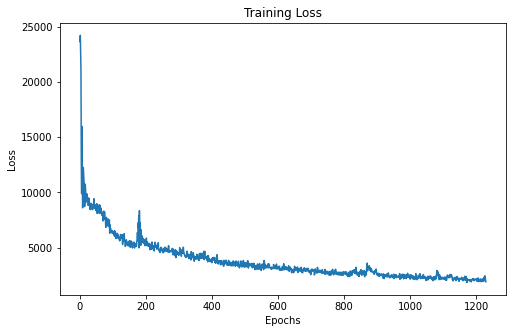

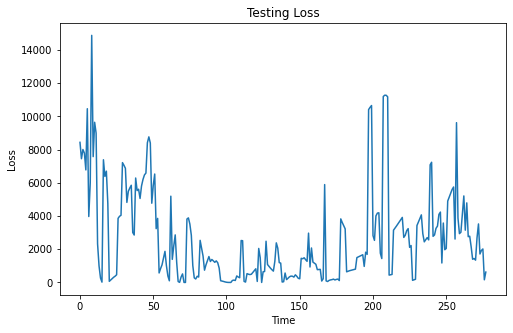

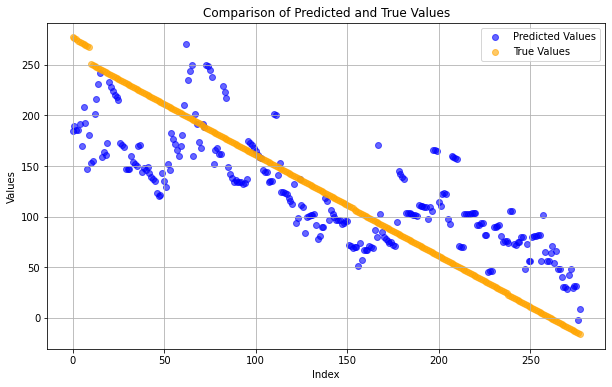

In [26]:
#Plot Training Loss Values
step = range(len(loss_values))

fig, ax = plt.subplots(figsize=(8,5))
plt.plot(step, np.array(loss_values))
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

#Plot Testing Loss Values
step = range(len(eval_loss_values))

fig, ax = plt.subplots(figsize=(8,5))
plt.plot(step, np.array(eval_loss_values))
plt.title("Testing Loss")
plt.xlabel("Time")
plt.ylabel("Loss")
plt.show()


#Plot Predicted Values vs Actual Values
plt.figure(figsize=(10, 6))
plt.scatter(range(len(predicted_values)), predicted_values, label='Predicted Values', color='blue', alpha=0.6)
plt.scatter(range(len(true_values)), true_values, label='True Values', color='orange', alpha=0.6)

# Add labels and legend
plt.title('Comparison of Predicted and True Values')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()
plt.grid(True)

# Show plot
plt.show()

## Summary of Results
### Training Loss
### As we can see from the training loss graph over time the loss decreases indicating that the model is learning and adapting accordingly. We can see that the loss does stall at a certain time before decreasing again. This can be attributed to the fact that it switches to learning how to calculate the number of moves left from when the algorithm does not know where the bot is (phase 1) to when it does know where the bot is (phase 2). This switch from learning more from the bot knowledge base to the rat knowledge base may lead to a temporary stagnation in the the loss function. However, after a brief time the loss function sharply decreases again. 
### Testing Loss
### The testing loss on average is more consistent because it shows our model's ability to generalize the information it has access to and is not changing or adapting based on the values. This also explains why it generally is far lower than the training loss on average. The model has already learned, now it is simply predicting the number of moves left based on the given input. Compared to the training loss when starting, the testing loss, even if it occasionally spikes, is significantly lower overall, indicating that the model is relatively accurate. 
### Comparison of Predicted Values and Actual Values
### We can see from this graph that our model tries to predict the number of moves left with the given states. Something we noticed is that if the total moves of the testing output is significantly lower than the average in the training model our CNN has a difficult time predicting the number of moves left. On the other hand if the testing output more closely resembles that of the average simulation used in the training input our CNN works better. We recommend running the simulation overall mutliple times as overall the CNN does seem to learn and understand how to make the predicition given enough time. Especially towards the later time steps it is better able to get a more accurate prediction. We showcased our graphs from our training and testing as well.

## Stretch Goal
### Adjusting Phase 1 and Phase 2 to utilize CNN and compare decisions

In [27]:
#Find the CNN suggested decision for phase 1
def p1_find_cnn_suggested_decision(ship, bot_pos, possible_bot_pos, possible_rat_pos):
    x, y = bot_pos

    #Keep track of the inputs with the key as the decision and value as the state
    inputs = {"sense": None, "up" : None, "down" : None, "left" : None, "right" : None}

    #Check the state if the bot senses
    sense_possible_bot_pos = copy.deepcopy(possible_bot_pos)
    num_blocked_neighbors = get_num_blocked_neighbors(ship, x, y)  
    sense_possible_bot_pos = update_possible_bot_pos_by_neighbors(ship, num_blocked_neighbors, sense_possible_bot_pos)
    
    sense_input_tensor = create_input_tensor(RawData(ship, possible_rat_pos, sense_possible_bot_pos, None))
    inputs["sense"] = sense_input_tensor

    #Check state if the bot moves up
    if ship[x - 1][y] == "open":
        up_possible_bot_pos = update_possible_bot_pos_by_move(ship, "up", True, copy.deepcopy(possible_bot_pos))
        up_input_tensor = create_input_tensor(RawData(ship, possible_rat_pos, up_possible_bot_pos, None))
        inputs["up"] = up_input_tensor

    #Check the state if the bot moves down
    if ship[x + 1][y] == "open":
        down_possible_bot_pos = update_possible_bot_pos_by_move(ship, "down", True, copy.deepcopy(possible_bot_pos))
        down_input_tensor = create_input_tensor(RawData(ship, possible_rat_pos, down_possible_bot_pos, None))
        inputs["down"] = down_input_tensor
    
    #Check the state if the bot moves left
    if ship[x][y - 1] == "open":
        left_possible_bot_pos = update_possible_bot_pos_by_move(ship, "left", True, copy.deepcopy(possible_bot_pos))
        left_input_tensor = create_input_tensor(RawData(ship, possible_rat_pos, left_possible_bot_pos, None))
        inputs["left"] = left_input_tensor
        
    #Check the state if the bot moves right
    if ship[x][y + 1] == "open":
        right_possible_bot_pos = update_possible_bot_pos_by_move(ship, "right", True, copy.deepcopy(possible_bot_pos))
        right_input_tensor = create_input_tensor(RawData(ship, possible_rat_pos, right_possible_bot_pos, None))
        inputs["right"] = right_input_tensor
    
    cnn_suggested_decision = None
    min_moves_left = float("inf")

    cnn.eval()

    with torch.no_grad():
        # Iterate over inputs
        for decision, input in inputs.items():
            # Get the input and corresponding ground truth output
            if input is not None and input.size > 0:  
                input_tensor = torch.tensor(input, dtype=torch.float32)
                cnn_input = input_tensor.unsqueeze(0)  # Add batch dimension
                prediction = cnn(cnn_input)

                #Set the decision to the min prediction
                if prediction < min_moves_left:
                    cnn_suggested_decision = decision
                    min_moves_left = prediction
    
    return cnn_suggested_decision

def stretch_goal_my_phase_1(ship, bot_pos, possible_bot_pos, possible_rat_pos):
    x, y = bot_pos  # Initial bot position
    wiggle = []  # List to track movement patterns
    last_move_sense_neighbors = False  # Flag to track last move type
    num_sense_blocked_neighbors = 0  # Count of sense operations
    num_attempted_moves = 0  # Count of attempted moves

    cnn_suggested_decision = []
    taken_decision = []

    # Loop until only one possible bot position is left
    while True:

        #Appends the current states of the ship to the states array in order to be used for training data
        # states.append([ship, possible_rat_pos, possible_bot_pos, num_sense_blocked_neighbors + num_attempted_moves])

        if len(possible_bot_pos) == 1:
            return [possible_bot_pos.pop(), cnn_suggested_decision, taken_decision]
        
        #Find the cnn suggested decision at the current state
        cnn_suggested_decision.append(p1_find_cnn_suggested_decision(ship, bot_pos, possible_bot_pos, possible_rat_pos))
        
        #Calculate the state depending on sense, up, down, left, and right
        
        # Calculate utilities for sensing neighbors and moving
        utility_sense_neighbors = get_utility_sense_neighbors(ship, possible_bot_pos)
        utility_move = get_utility_move(ship, possible_bot_pos)

        # Choose the action depending on which utility is higher - which action causes the greatest reduction in number of possible bot positions
        if utility_sense_neighbors >= utility_move and not last_move_sense_neighbors:
            taken_decision.append("sense")
            #Sensing two times in a row from the same position does not provide much benefit

            #Code below senses for blocked neighbors then adjusts the possible bot positions
            num_sense_blocked_neighbors += 1  
            num_blocked_neighbors = get_num_blocked_neighbors(ship, x, y)  
            possible_bot_pos = update_possible_bot_pos_by_neighbors(ship, num_blocked_neighbors, possible_bot_pos)
            last_move_sense_neighbors = True
        else:

            last_move_sense_neighbors = False
            num_attempted_moves += 1

            # Check for a wiggle and if it exists randomly choose a direction
            if len(wiggle) > 3 and (wiggle[0] == wiggle[2] and wiggle[1] == wiggle[3]):
                directions = ["up", "down", "left", "right"]
                direction = random.choice(directions)
            else:
                # Calculate probabilities for each direction based on open paths
                direction_counts = {
                    "up": 0,
                    "down": 0,
                    "left": 0,
                    "right": 0
                }
                for (x, y) in possible_bot_pos:
                    if ship[x - 1][y] == "open":
                        direction_counts["up"] += 1
                    if ship[x + 1][y] == "open":
                        direction_counts["down"] += 1
                    if ship[x][y - 1] == "open":
                        direction_counts["left"] += 1
                    if ship[x][y + 1] == "open":
                        direction_counts["right"] += 1

                # Calculate direction probabilities based on counts
                direction_prob = {key: value / len(possible_bot_pos) for key, value in direction_counts.items()}
                directions = list(direction_prob.keys())
                probabilities = list(direction_prob.values())
                direction = random.choices(directions, probabilities, k=1)[0]

            # Attempt to move in the selected direction and update position
            move_success = False
            if direction == "up" and ship[x-1][y] == "open":
                x -= 1
                move_success = True
            if direction == "down" and ship[x+1][y] == "open":
                x += 1
                move_success = True
            if direction == "left" and ship[x][y-1] == "open":
                y -= 1
                move_success = True
            if direction == "right" and ship[x][y+1] == "open":
                y += 1
                move_success = True

            taken_decision.append(direction)
            
            #Update the wiggle list to keep track of our movements
            if move_success:
                wiggle.append(direction)
                if len(wiggle) > 4:
                    wiggle = wiggle[1:]

            # Update possible bot positions based on the move and if it was successful
            possible_bot_pos = update_possible_bot_pos_by_move(ship, direction, move_success, possible_bot_pos)
            

In [28]:
#Find the cnn suggested decision for phase 2
def p2_find_cnn_suggested_decision(ship, bot_pos, rat_pos, possible_bot_pos, possible_rat_pos, a):
    inputs = {"ping": None, "up" : None, "down" : None, "left" : None, "right" : None}
    x, y = bot_pos
    rx, ry = rat_pos
    
    #Check state if ping
    ping_inputs = []
    
    ping_possible_rat_pos = update_possible_rat_pos(x, y, True, a, copy.deepcopy(possible_rat_pos))
    ping_input_tensor = create_input_tensor(RawData(ship, ping_possible_rat_pos, possible_bot_pos, None))
    ping_inputs.append(ping_input_tensor)

    #Check state if not ping
    not_ping_possible_rat_pos = update_possible_rat_pos(x, y, False, a, copy.deepcopy(possible_rat_pos))
    not_ping_input_tensor = create_input_tensor(RawData(ship, not_ping_possible_rat_pos, possible_bot_pos, None))
    ping_inputs.append(not_ping_input_tensor)

    inputs["ping"] = np.array(ping_inputs)

    #Check state if the bot moves up
    if ship[x - 1][y] == "open":
        up_possible_bot_pos = {(x-1, y)}
        up_input_tensor = create_input_tensor(RawData(ship, possible_rat_pos, up_possible_bot_pos, None))
        inputs["up"] = up_input_tensor

    #Check the state if the bot moves down
    if ship[x + 1][y] == "open":
        down_possible_bot_pos = {(x+1, y)}
        down_input_tensor = create_input_tensor(RawData(ship, possible_rat_pos, down_possible_bot_pos, None))
        inputs["down"] = down_input_tensor
    
    #Check the state if the bot moves left
    if ship[x][y - 1] == "open":
        left_possible_bot_pos = {(x, y-1)}
        left_input_tensor = create_input_tensor(RawData(ship, possible_rat_pos, left_possible_bot_pos, None))
        inputs["left"] = left_input_tensor
        
    #Check the state if the bot moves right
    if ship[x][y + 1] == "open":
        right_possible_bot_pos = {(x, y+1)}
        right_input_tensor = create_input_tensor(RawData(ship, possible_rat_pos, right_possible_bot_pos, None))
        inputs["right"] = right_input_tensor
    
    cnn_suggested_decision = None
    min_moves_left = float("inf")

    cnn.eval()
    # Disable gradient calculations for faster inference
    with torch.no_grad():
        # Iterate over inputs
        for decision, input in inputs.items():
            # Get the input and corresponding ground truth output
            if input is not None and input.size > 0: 
                #Account for the fact that a ping can and cannot occur
                if decision == "ping":
                    ping_input = input[0]
                    not_ping_input = input[1]

                    ping_input_tensor = torch.tensor(ping_input, dtype=torch.float32)
                    cnn_input = ping_input_tensor.unsqueeze(0) 
                    ping_prediction = cnn(cnn_input)

                    not_ping_input_tensor = torch.tensor(not_ping_input, dtype=torch.float32)
                    cnn_input = not_ping_input_tensor.unsqueeze(0)
                    not_ping_prediction = cnn(cnn_input)

                    prob_ping = get_ping(x, y, rx, ry, a)

                    prediction = ping_prediction*prob_ping + not_ping_prediction*(1-prob_ping)

                else: 
                    input_tensor = torch.tensor(input, dtype=torch.float32)
                    cnn_input = input_tensor.unsqueeze(0)
                    prediction = cnn(cnn_input)

                #Assign the decision to the min prediction
                if prediction < min_moves_left:
                    cnn_suggested_decision = decision
                    min_moves_left = prediction
    
    return cnn_suggested_decision

def stretch_goal_my_bot_phase_2(ship, bot_pos, rat_pos, possible_rat_pos, a):

    #Initialze variables
    bx, by = bot_pos 
    rx, ry = rat_pos 
    time = 0
    num_ping = 0 
    num_moves = 0 
    mandatory_ping = False  # Check for mandatory pinging 
    visit = set()  # Set to track visited positions when moving without pinging
    visit.add((bx, by)) 
    commit = False  # Check to commit to a a high probability cell
    commit_next_move = False  # Check to commit on the next move

    cnn_suggested_decision = []
    taken_decision = []

    while True:
        
        if 0 < a <= 0.1:
            ping_factor = 0.6
        if 0.1 < a <= 0.2:
            ping_factor = 0.55


        #Find the CNN suggested move at the current state
        cnn_suggested_decision.append(p2_find_cnn_suggested_decision(ship, bot_pos, rat_pos, {(bx,by) : 1}, possible_rat_pos, a))

        #Factor to see how concentrated the values of the rat probability distribution are
        concentration = (ping_factor - max(possible_rat_pos.values()))
  
        #If concentration is negative (very high probability value) commit to that cell
        if (concentration < 0 and not mandatory_ping) or commit:
            taken_decision.append("commit")
            # Select the best position to move to
            prx, pry = select_best_position(ship, bx, by, possible_rat_pos)
            num_moves += len(shortest_path_to_possible_rat_pos(ship, bx, by, prx, pry))  
            bx, by = prx, pry

            #Set mandatory_ping to ensure the next action is a ping
            mandatory_ping = True
            visit.add((prx, pry))

            commit = False

        # If concentration is low ping or if mandatory ping is true
        elif random.random() < concentration or mandatory_ping:
            taken_decision.append("ping")

            mandatory_ping = False  
            num_ping += 1 
            
            # Return if the rat is found
            if bx == rx and by == ry:
                # return [(bx, by), num_ping, num_moves, num_ping + num_moves]
                return [cnn_suggested_decision, taken_decision]
            
            # If the rat is not at the current cell set the probability to 0 and normalize
            possible_rat_pos[(bx, by)] = 0
            possible_rat_pos = {key: value / sum(possible_rat_pos.values()) for key, value in possible_rat_pos.items()}

            # Calculate the probability of hearing a ping and if ping happens
            prob_ping = get_ping(bx, by, rx, ry, a)
            ping = random.random() < prob_ping

            #Clear the visited cells
            visit.clear()

            # Update knowledge base depending on the ping result
            possible_rat_pos = update_possible_rat_pos(bx, by, ping, a, possible_rat_pos)
            
            #Set commit to true if commit next move is true
            if commit_next_move:
                commit = True
                commit_next_move = False

        #Code to choose how to move
        else:
            #Select the best position to move to
            prx, pry = select_best_position(ship, bx, by, possible_rat_pos)
            
            # Find the shortest path to the target position
            directions = shortest_path_to_possible_rat_pos(ship, bx, by, prx, pry) 

            if directions:

                new_x, new_y = directions[0]

                if new_x == bx - 1 and new_y == by:
                    taken_decision.append("up")
                elif new_x == bx + 1 and new_y == by:
                    taken_decision.append("down")
                elif new_x == bx and new_y == by - 1:
                    taken_decision.append("left")
                elif new_x == bx and new_y == by + 1:
                    taken_decision.append("right")

                #If the current cell is cell we need to move to ping and commit
                if directions[0] in visit:
                    mandatory_ping = True
                    commit_next_move = True
                else:
                    
                    #Move one position towards the best position
                    bx, by = directions[0]
                    visit.add((bx, by))
                    num_moves += 1
            else:
                taken_decision.append("stuck")
                #If the current cell is selected as the best position ping then commit to readjust the knowledge base
                mandatory_ping = True
                commit_next_move = True
      
        time += 1

In [29]:
#utilize the initial settings used for training on the stretch goals
init_ship, init_bot_pos, init_possible_bot_pos, init_rat_pos, init_possible_rat_pos = init_conditions

cnn_suggested_decision = []
taken_decisions = []

new_bot_pos, p1_cnn_suggested_decision, p1_taken_decisions = stretch_goal_my_phase_1(init_ship, init_bot_pos, init_possible_bot_pos, init_possible_rat_pos)

p2_cnn_suggested_decision, p2_taken_decisions = stretch_goal_my_bot_phase_2(init_ship, new_bot_pos, init_rat_pos, init_possible_rat_pos, a = 0.2)

cnn_suggested_decision.extend(p1_cnn_suggested_decision)
cnn_suggested_decision.extend(p2_cnn_suggested_decision)

taken_decisions.extend(p1_taken_decisions)
taken_decisions.extend(p2_taken_decisions)

for i in range(len(cnn_suggested_decision)):
    print(f'CNN Suggested Decision: {cnn_suggested_decision[i]} | Taken Decision: {taken_decisions[i]}')

CNN Suggested Decision: sense | Taken Decision: right
CNN Suggested Decision: right | Taken Decision: sense
CNN Suggested Decision: left | Taken Decision: down
CNN Suggested Decision: sense | Taken Decision: sense
CNN Suggested Decision: down | Taken Decision: right
CNN Suggested Decision: down | Taken Decision: sense
CNN Suggested Decision: left | Taken Decision: right
CNN Suggested Decision: left | Taken Decision: ping
CNN Suggested Decision: left | Taken Decision: ping
CNN Suggested Decision: left | Taken Decision: ping
CNN Suggested Decision: left | Taken Decision: ping
CNN Suggested Decision: left | Taken Decision: ping
CNN Suggested Decision: left | Taken Decision: ping
CNN Suggested Decision: left | Taken Decision: right
CNN Suggested Decision: left | Taken Decision: down
CNN Suggested Decision: left | Taken Decision: down
CNN Suggested Decision: left | Taken Decision: right
CNN Suggested Decision: left | Taken Decision: down
CNN Suggested Decision: left | Taken Decision: ping
C

## Graph Decisions to Show Comparisons

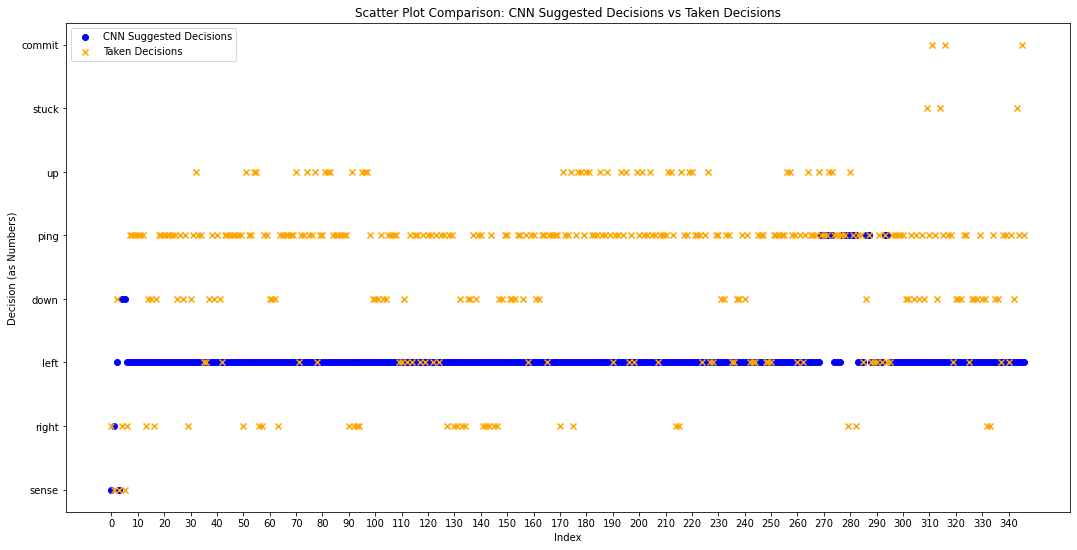

In [30]:

x = np.arange(len(cnn_suggested_decision))

# Scatter plot
plt.figure(figsize=(18, 9))

plt.scatter(x, cnn_suggested_decision, color='blue', label='CNN Suggested Decisions', marker='o')
plt.scatter(x, taken_decisions, color='orange', label='Taken Decisions', marker='x')

plt.title('Scatter Plot Comparison: CNN Suggested Decisions vs Taken Decisions')
plt.xlabel('Index')
plt.ylabel('Decision (as Numbers)')
plt.xticks(ticks=x[::10], labels=x[::10])
plt.legend()

plt.show()


## Summary of Stretch Goal Approach, Code, Findings
### Explanation of Code:
### Our code utilizes our CNN trained model to figure out the "optimal" decision at every timestep in the both phase 1 and phase 2 of my bot. At every time step we calculate the possible states for every decision and get a predicition on how many moves will be left. Then we set the "optimal" decision to whichever prediction is the lowest. Then we track the actual decision that our bot makes
### Explanation of Findings
### Instead of moving in the best possible direction based on the shortest possible path (bot algorithm), the CNN suggests the decision that reduces the overall moves left, which may not fall on the shortest path. On top of this, our CNN tends to favor pinging, which is in theory the optimal move to do. However, the bot has a random element when deciding whether to ping or not. This factor results in the bot pinging fewer times than recommended by the CNN. The CNN is also unable to factor in moves such as 'commit', which are edge cases that the bot encounters, as it looks at the algorithm holistically, as opposed to a case-by-case basis. As shown by the graph, the CNN will often recommend the same move multiple times in a row, as if the bot chooses a different move, the CNN will consider its move as still the best option. 
